In [1]:
# Initial project direcctory setup

!mkdir -p data
!wget -c "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json" -O "data/stanford_train_data.json"
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -df "GoogleNews-vectors-negative300.bin.gz"


Redirecting output to ‘wget-log.10’.

Redirecting output to ‘wget-log.11’.


In [45]:
# Install the requried libraries 

!pip install tqdm
!pip install Whoosh
!pip install gensim

    100% |████████████████████████████████| 51kB 3.5MB/s 


In [1]:
import os
import nltk
import json
import gensim
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from whoosh.fields import Schema, ID, KEYWORD, TEXT
from whoosh.index import create_in
from whoosh.query import Term
from whoosh.qparser import QueryParser
from whoosh import scoring
from whoosh import qparser
from IPython.display import display, HTML

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# Generate dataframe from SQuAD json file

squad_data = json.loads(open("data/stanford_train_data.json").read())['data']

squad_para_df      = pd.DataFrame(columns=['id', 'title', 'context'])
squad_questions_df = pd.DataFrame(columns=['id', 'para_id', 'question'])
squad_answers_df   = pd.DataFrame(columns=['question_id', 'answer_start', 'answer_text'])

paraIdx = 0
for document in tqdm(squad_data):
    for paragraph in document['paragraphs']:     
        p = unicodedata.normalize('NFD', paragraph['context']).encode('ascii', 'ignore')
        squad_para_df = squad_para_df.append({'id': paraIdx, 'title': document['title'], \
                                              'context': p}, ignore_index=True)        
        for qas in paragraph['qas']:
            q = unicodedata.normalize('NFD', qas['question']).encode('ascii', 'ignore')
            squad_questions_df = squad_questions_df.append({'id' : qas['id'], 'para_id': paraIdx, \
                                                            'question': q}, ignore_index=True)
            
            for answer in qas['answers']:
                a = unicodedata.normalize('NFD', answer['text']).encode('ascii', 'ignore')
                squad_answers_df = squad_answers_df.append({'question_id': qas['id'], \
                                                            'answer_start': answer['answer_start'], \
                                                            'answer_text': a}, ignore_index=True)
        paraIdx += 1

squad_para_df.to_csv('data/squad_paragraphs.tsv', sep='\t')
squad_questions_df.to_csv('data/squad_questions.tsv', sep='\t')
squad_answers_df.to_csv('data/squad_answers.tsv', sep='\t')

In [3]:
# Build indexes for the SQuAD dataset

!rm -r squad_index

SQUAD_INDEX_DIR = "squad_index"

schema = Schema(content=TEXT, idx=ID(unique=True, stored=True))
 
# Create index dir if it does not exists.
if not os.path.exists(SQUAD_INDEX_DIR):
    os.mkdir(SQUAD_INDEX_DIR)

# Initialize index
search_index = create_in(SQUAD_INDEX_DIR, schema)

# Fill index with posts from DB
writer = search_index.writer()

squad_para_df = pd.read_csv('data/squad_paragraphs.tsv', sep='\t', header=0)

for sqIdx, row in tqdm(squad_para_df.iterrows(), total=squad_para_df.shape[0]):
    writer.update_document(content=row['context'], idx=str(row['id']))

writer.commit()

100%|██████████| 18896/18896 [00:21<00:00, 887.02it/s] 


In [4]:
# We identify the main intent of a question through POS tagging wherein which 
# we currently select the adjectives and the common noun words

tags_to_process = ('JJ', 'NN')

def fetch_intent_from_question(text):
    tokenized = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)
    entities = [word for word, tag in tagged if tag.startswith(tags_to_process)]
    
    return entities

fetch_intent_from_question("What is affecting global warming?")

['global', 'warming']

In [5]:
# Initialize the Whoosh searcher which looks up the indexes to fetch the documents
# related to the provided question

searcher = search_index.searcher()
og = qparser.OrGroup.factory(0.95)
qp = QueryParser("content", schema=search_index.schema, group=og)


def find_candidate_answer_set(Q):
    intent = fetch_intent_from_question(Q)
    query = qp.parse(" ".join(intent))

    result = searcher.search(query, limit=100)
    
    result_index_list = []
    for r in result: result_index_list.append(int(r['idx']))
    
    return result_index_list

Q = "What is in front of the Notre Dame Main Building?"
squad_para_df = pd.read_csv('data/squad_paragraphs.tsv', sep='\t', header=0)
result_index_list = find_candidate_answer_set(Q)
display(squad_para_df.iloc[result_index_list])

,id,title,context
7,7,University_of_Notre_Dame,The library system of the university is divide...
38,38,University_of_Notre_Dame,The University of Notre Dame du Lac (or simply...
27,27,University_of_Notre_Dame,"Since 2005, Notre Dame has been led by John I...."
2,2,University_of_Notre_Dame,The university is the major seat of the Congre...
6,6,University_of_Notre_Dame,The Joan B. Kroc Institute for International P...
31,31,University_of_Notre_Dame,The University of Notre Dame has made being a ...
52,52,University_of_Notre_Dame,"The ""Notre Dame Victory March"" is the fight so..."
17,17,University_of_Notre_Dame,The university is affiliated with the Congrega...
20,20,University_of_Notre_Dame,One of the main driving forces in the growth o...
22,22,University_of_Notre_Dame,Holy Cross Father John Francis O\'Hara was ele...


  3%|▎         | 2999/87599 [02:35<1:18:41, 17.92it/s]

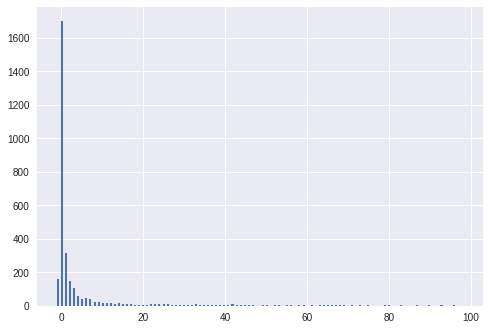

In [6]:
# Generate histogram of the answer index distribution, that is, from the obtained document list
# from the searcher, at which index does the sentence containing the answer lies for each question

COLLECTOR_LIMIT = 3000

collector = []
squad_questions_df = pd.read_csv('data/squad_questions.tsv', sep='\t', header=0)
for idx, row in tqdm(squad_questions_df.iterrows(), total=squad_questions_df.shape[0]):
    result_index_list = find_candidate_answer_set(row['question'])
    if row['para_id'] in result_index_list: collector.append(result_index_list.index(row['para_id']))
    else: collector.append(-1)
    if len(collector) >= COLLECTOR_LIMIT: break

plt.hist(collector, bins=200)
plt.show()

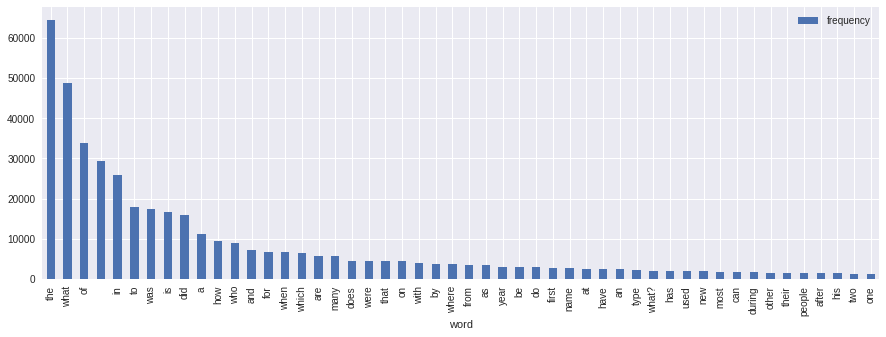

In [7]:
# Build a histogram of the commonly occuring terms in the questions to gain more insights
# regarding the type of questions asked

from collections import Counter

squad_questions_df = pd.read_csv('data/squad_questions.tsv', sep='\t', header=0)
questions = squad_questions_df.question.str.cat(sep=' ')

commo_terms_list = Counter(questions.lower().split(' ')).most_common(50)

common_terms_df = pd.DataFrame(commo_terms_list, columns=['word', 'frequency'])
common_terms_df.plot(kind='bar', x='word', figsize=(15,5))

# Commonly occuring question words: what, when, which, how, where, be

In [8]:
# Formulate dataset for training

squad_paragraphs_df = pd.read_csv('data/squad_paragraphs.tsv', sep='\t', header=0)
squad_answers_df = pd.read_csv('data/squad_answers.tsv', sep='\t', header=0)
squad_questions_df = pd.read_csv('data/squad_questions.tsv', sep='\t', header=0)

combi = pd.merge(squad_answers_df, squad_questions_df, left_on='question_id', right_on='id')
combi.drop(['question_id', 'id'], axis=1, inplace=True)
combi = pd.merge(squad_paragraphs_df, combi, left_on='id', right_on='para_id')
combi.drop(['para_id', 'id', 'title'], axis=1, inplace=True)
combi['context'] = combi.progress_apply(lambda x: x.context[:x.answer_start] + " <#ANSWER> " + x.context[x.answer_start:], axis=1)

rows = []
combi.progress_apply(lambda row: [rows.append([row['question'], row['answer_text'], sent, "<#ANSWER>" in sent]) 
                         for sent in nltk.sent_tokenize(row['context'])], axis=1)
df = pd.DataFrame(rows, columns=['question', 'answer_text', 'sentence', 'target'])

feature_df = df
feature_df.sentence = feature_df.sentence.progress_apply(lambda x: x.replace('<#ANSWER>', ''))


100%|██████████| 446952/446952 [00:00<00:00, 561163.68it/s]

In [0]:
# Backup main feature_base 

feature_df.to_csv('data/question_answers_df.tsv', sep='\t')

In [0]:
feature_df = pd.read_csv('data/question_answers_df.tsv', sep='\t', header=0)

# To randomly sample a smaller dataset uncomment the following line:
# feature_df = feature_df.sample(frac=0.1, random_state=4)

feature_df.question.astype('str', inplace=True)
feature_df.answer_text.astype('str', inplace=True)
feature_df.sentence.astype('str', inplace=True)

feature_df.columns.values[0] = 'index_id'
feature_df.dropna(axis=0, how='any', inplace=True)

print (feature_df.dtypes)
display(feature_df.head())

In [0]:
# Load Google's pre-trained Word2Vec model.

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

### Feature: Exact Match

Calculates the total number of stemmed words which belongs to both the question and the sentence being analyzed.

In [0]:
from collections import Counter
from nltk.stem import PorterStemmer

def feature_exact_match(row):
    ps = PorterStemmer()
    return sum(
        (
            Counter([ps.stem(x) for x in row['sentence'].lower().split()]) 
            & 
            Counter([ps.stem(x) for x in row['question'].lower().split()])
        ).values()
    )
feature_df['exact_match'] = feature_df.progress_apply(feature_exact_match, axis=1)

### Feature: Alignment Score

We use the Word Mover's Distance (WMD) to calculate how closely a sentence aligns to the given question using Google Word2Vec embedded word vectors. The research paper discussing the approach is present here: http://proceedings.mlr.press/v37/kusnerb15.pdf

In [0]:
import itertools

def feature_alignment_score(row):
    intents = [x for x in fetch_intent_from_question(row['question']) if x in w2v_model.vocab]
    tokens = [x for x in nltk.word_tokenize(row['sentence']) if x in w2v_model.vocab]
    total_items = len(intents) * len(tokens)
    iter_items = itertools.product(intents, tokens)
    alignment_score = 0.0
    for a, b in iter_items:
        alignment_score += w2v_model.distance(a, b)
    if total_items == 0: return float('NaN')
    return alignment_score / total_items
feature_df['alignment_score'] = feature_df.progress_apply(feature_alignment_score, axis=1)

### Feature: Max Alignment Score

We modify the above mentioned Word Mover's Distance in a manner to calculate the score of the maximum aligned intent term from the question to any other word in the sentence.

In [0]:
def feature_max_alignment(row):
    intents = [x for x in fetch_intent_from_question(row['question']) if x in w2v_model.vocab]
    tokens =  [x for x in fetch_intent_from_question(row['sentence']) if x in w2v_model.vocab]
    if len(intents) * len(tokens) == 0: return float('NaN')
    max_alignment_score = 0.0
    for intent in intents:
        max_alignment_score += np.min([w2v_model.distance(x, intent) for x in tokens])
    return max_alignment_score / len(intents)
feature_df['max_alignment'] = feature_df.progress_apply(feature_max_alignment, axis=1)

### Feature: Number of Intent Words

As mentioned previously, we term a word belonging to the Question to be an `intent word` if it's identified to be an Adjective or a Common Noun by a Part-Of-Speech tagger.

In [0]:
def feature_number_of_intent(row):
    intents = [x for x in fetch_intent_from_question(row['question']) if x in w2v_model.vocab]
    return len(intents)
feature_df['number_of_intent'] = feature_df.progress_apply(feature_number_of_intent, axis=1)

In [0]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

### Feature: Count Vectorizer Match

We build count vectors for every question and sentence and calculate the total matching words between each pair after lemmatizing the each of them.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(tokenizer=LemmaTokenizer(), analyzer='word',token_pattern=r'\w{1,}', 
                      ngram_range=(1, 2), stop_words = 'english')
ctv.fit(feature_df.sentence.values + feature_df.question.values)

sent_ctv = ctv.transform(feature_df.sentence.values)
ques_ctv = ctv.transform(feature_df.question.values)

ctv_score = []
for s, q in tqdm(zip(sent_ctv, ques_ctv), total=sent_ctv.shape[0]):
    dot = s.dot(q.T).data
    val = dot[0] if len(dot) else 0
    ctv_score.append(val)
    
feature_df['count_vectorizer_match'] = pd.Series(ctv_score).values

### Feature: Tf-Idf Match Score

We calculate the TF-IDF (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) values for the entire vocabulary spanning over question and sentences corpus. We then use these values to vectorize each question and sentence. The Tf-Idf match between any question-sentence pair is then calculated as the dot product between these two vectors.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(feature_df.sentence.values + feature_df.question.values)

sent_tfv = tfv.transform(feature_df.sentence.values)
ques_tfv = tfv.transform(feature_df.question.values)

print (sent_tfv.shape)

tfv_score = []
for s, q in tqdm(zip(sent_tfv, ques_tfv), total=sent_tfv.shape[0]):
    dot = s.dot(q.T).data
    val = dot[0] if len(dot) else 0.0
    tfv_score.append(val)

feature_df['tfidf_match'] = pd.Series(tfv_score).values

### Feature: Question Coverage

We define the coverage for a given question-sentence pair as the ratio of the exactly matched words between the question and the sentence over the total number of words in the question.

In [57]:
feature_df['question_words'] = feature_df.question.apply(lambda x: len(x.split()))
feature_df['coverage'] = feature_df.exact_match / feature_df.question_words

# Handle missing/null data

feature_df.alignment_score.fillna(-1.0, inplace=True)
feature_df.max_alignment.fillna(-1.0, inplace=True)
display(feature_df)

,index_id,question,answer_text,sentence,target,exact_match,alignment_score,max_alignment,number_of_intent,count_vectorizer_match,tfidf_match,question_words,coverage
68873,68873,Where is the theater District located?,south of Boston Common,Other performing-arts organizations located in...,False,1,0.881072,5.594476e-01,2,1,0.025818,6,0.166667
195732,195732,Where can the public view the Royal Collection?,at the Queen's Gallery,"It is not the monarch's personal property, unl...",False,1,0.879658,7.210963e-01,3,0,0.000000,8,0.125000
301126,301126,How many players can an NFL team have in the o...,90,"Split-squad games, a practice common in baseba...",False,3,0.810726,4.730812e-01,4,2,0.100368,11,0.272727
318729,318729,What document declares supreme power for the p...,the Constitution of Estonia,The people exercise their supreme power of the...,False,3,0.828007,2.086947e-01,4,4,0.354543,8,0.375000
193367,193367,What value does Deloitte place on Arsenal?,331.3m,"3m (435.5m), ranking Arsenal seventh among wo...",True,0,0.855577,6.227328e-01,4,1,0.114317,7,0.000000
20510,20510,Which city in North America held the most slav...,"Charleston, South Carolina","It also became a center of slavery, with 42% o...",True,2,0.865245,3.315323e-01,5,2,0.081870,12,0.166667
320616,320616,"Compared to the rest of the US, does Alaska ha...",few,The western part of Alaska has no road system ...,False,7,0.850673,4.609409e-01,7,7,0.470676,15,0.466667
56702,56702,From what passage is cited as being one of the...,Nag Hammadi's Apocalypse of Peter,"However, his accusers were excommunicated both...",False,2,0.908814,6.398091e-01,6,1,0.078640,18,0.111111
343785,343785,What religion was at the center of education i...,Islam,Wiesner-Hanks also says that Protestants also ...,False,0,0.884671,7.056823e-01,5,0,0.000000,12,0.000000
129620,129620,What type of carrier is the Charles de Gaulle?,CATOBAR,"1 CATOBAR carrier: Charles de Gaulle is a 42,0...",False,5,0.853132,2.051662e-01,4,5,0.384170,9,0.555556


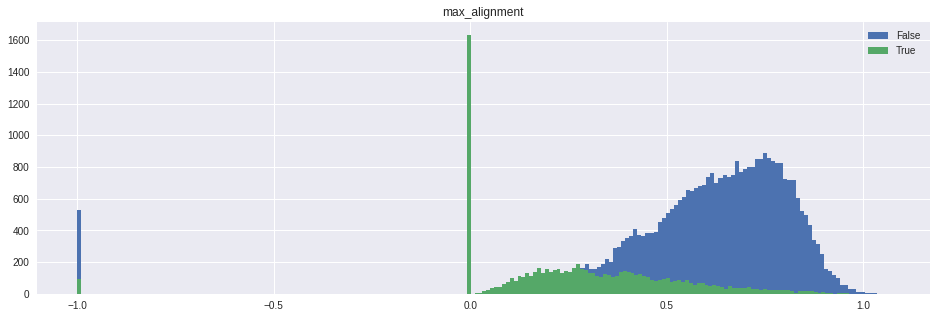

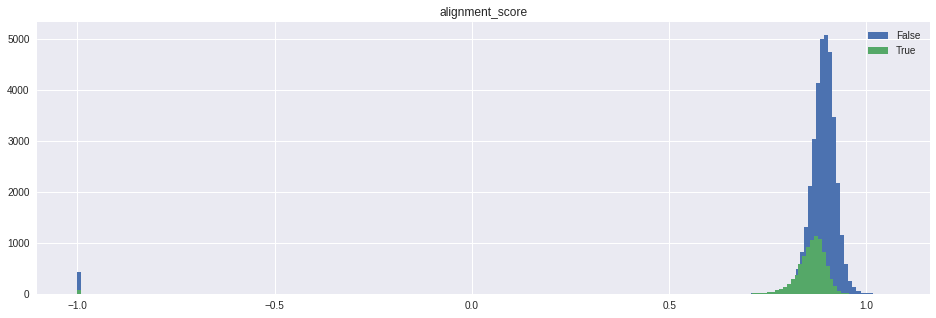

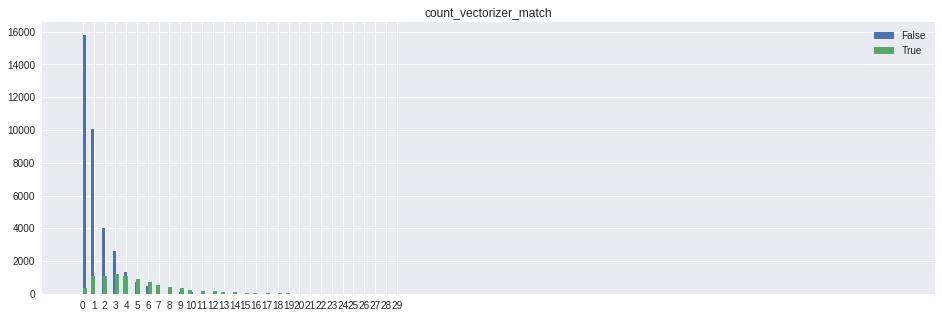

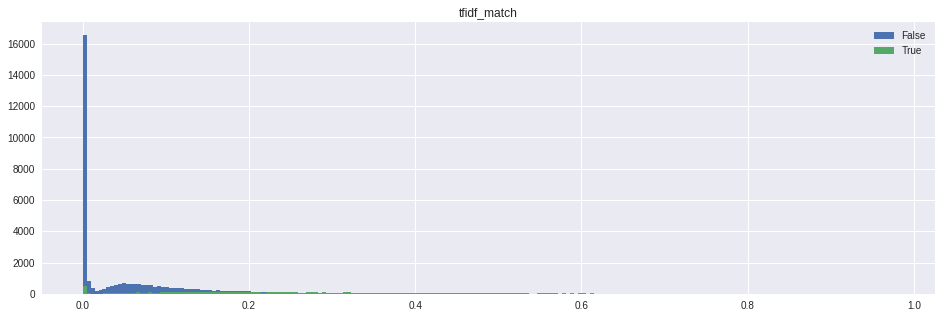

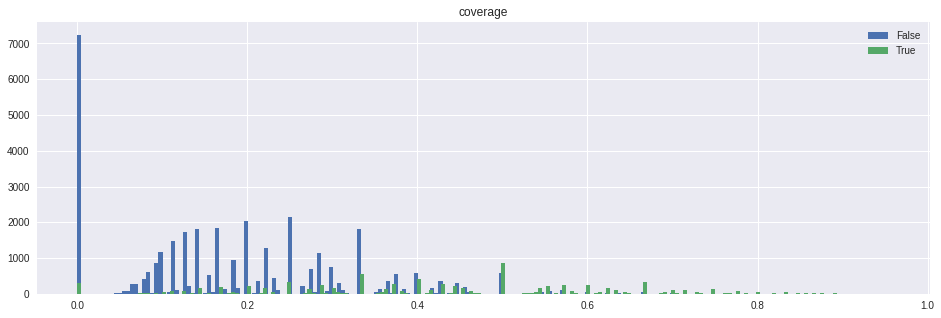

In [84]:
feature_to_test = 'count_vectorizer_match'

def plot_feature_hist(feature_to_test, xticks=[], bins=200):
    plt.figure(figsize=(16,5))
    plt.hist(feature_df[feature_df.target == 0][feature_to_test], bins=bins, label='False')
    plt.hist(feature_df[feature_df.target == 1][feature_to_test], bins=bins, label='True')
    plt.legend(loc='upper right')
    plt.title(feature_to_test)
    if len(xticks): plt.xticks(xticks)
    plt.show()

plot_feature_hist('max_alignment')
plot_feature_hist('alignment_score')
plot_feature_hist('count_vectorizer_match', list(range(0, 30,1)))
plot_feature_hist('tfidf_match')
plot_feature_hist('coverage')

In [0]:
# save features as csv

feature_df.to_csv('data/feature_df_all.tsv', sep='\t')

AuC:  0.8985756363492077
Accuracy score:  0.865955542294495
[[9700 1090]
 [ 707 1909]]
             precision    recall  f1-score   support

          0       0.93      0.90      0.92     10790
          1       0.64      0.73      0.68      2616

avg / total       0.87      0.87      0.87     13406



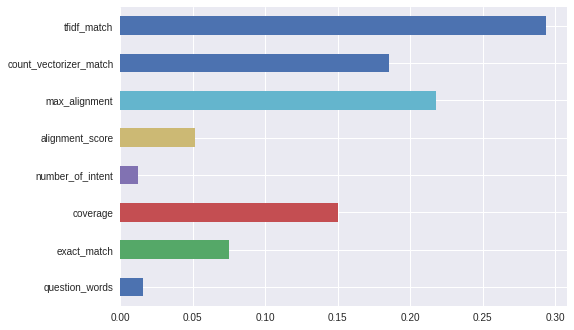

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

features = feature_df[['question_words', 'exact_match', 'coverage', 'number_of_intent', \
                       'alignment_score', 'max_alignment', 'count_vectorizer_match', 'tfidf_match']]
target = feature_df['target'].map({True: 1, False: 0})

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=6)
 
model = RandomForestClassifier(n_estimators=10, max_depth=8, random_state=0, class_weight={0: 1, 1: 2.5})
model = model.fit(features_train, target_train)

(pd.Series(model.feature_importances_, index=features.columns).plot(kind='barh')) 

predicted = model.predict(features_test)
probs = model.predict_proba(features_test)
# print (probs)
print ("AuC: ", metrics.roc_auc_score(target_test, probs[:, 1]))
 
print ("Accuracy score: ", metrics.accuracy_score(target_test, predicted))
print (metrics.confusion_matrix(target_test, predicted))
print (metrics.classification_report(target_test, predicted))


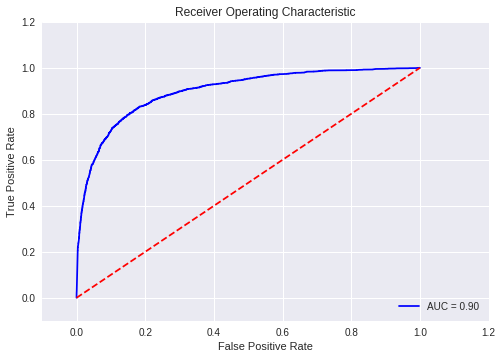

In [78]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, probs[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
from sklearn.externals import joblib

filename = 'model/random_forest_model_sample.sav'
joblib.dump(model, filename)

['random_forest_model_sample.sav']